In [1]:
import numpy as np
import geopandas as gpd 
# import geoplot as gplt
# import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import pandas as pd
import os

This code block is the call to API to get data for the specified year. Then it filters this data to get just columns required for the visualization.

In [2]:
import json
import requests

# Set Year
year = 2022

# API endpoint
url = "https://data.buffalony.gov/resource/d6g9-xbgu.json"

# Add query parameters to limit the number of results
params = {
    "$where": f"incident_datetime between '{year}-01-01T00:00:00.000' and '{year}-12-31T23:59:59.000'",
    "$limit": 100000
}

response = requests.get(url, params=params)

# Status Code 200 means successful query
if response.status_code == 200:
    # Parse the JSON data
    crime_incidents = response.json()

    crime_incidents_df = pd.DataFrame.from_records(crime_incidents, columns=['incident_datetime', 'incident_type_primary', 'longitude', 'latitude']).dropna()

else:
    print(f"Error: Unable to fetch data from API (status code {response.status_code})")

In [3]:
crime_incidents_df

incident_datetime incident_type_primary longitude latitude
0     2022-01-01T00:00:00.000         LARCENY/THEFT   -78.826   42.924
1     2022-01-01T00:00:00.000         LARCENY/THEFT   -78.867   42.948
2     2022-01-01T00:36:22.000               ASSAULT   -78.846    42.91
3     2022-01-01T00:46:00.000              BURGLARY   -78.808   42.919
4     2022-01-01T00:46:06.000               ASSAULT   -78.896   42.912
...                       ...                   ...       ...      ...
9472  2022-12-31T20:46:30.000         LARCENY/THEFT   -78.863   42.868
9473  2022-12-31T21:00:00.000               ASSAULT   -78.817   42.937
9474  2022-12-31T21:00:26.000                   UUV    -78.81    42.87
9475  2022-12-31T22:30:00.000              BURGLARY   -78.827   42.955
9476  2022-12-31T23:13:00.000               ASSAULT   -78.831    42.95

[8772 rows x 4 columns]

We have obtained the dataframe that consists of only the required columns to create the map. Our next goal is to plot these data points on a map of city of Buffalo with a legend that specifies the type of crime.

In [5]:
crime_weights = {
    "LARCENY/THEFT": 1,
    "UUV": 2,
    "ROBBERY": 3,
    "BURGLARY": 4,
    "ASSAULT": 5,
    "AGGR ASSAULT": 6,
    "RAPE": 7,
    "SEXUAL ABUSE": 8,
    "THEFT OF SERVICES": 1,
    "MURDER": 10,
    "Breaking & Entering": 4,
    "Theft": 1,
    "CRIM NEGLIGENT HOMICIDE": 9,
    "Sexual Assault": 7,
    "MANSLAUGHTER": 9,
    "AGG ASSAULT ON P/OFFICER": 6,
    "Theft of Vehicle": 2,
    "Homicide": 10,
    "Other Sexual Offense": 8,
    "SODOMY": 8,
}

In [6]:
import osmnx as ox
from shapely.geometry import Point

# Fetch the street network data of Buffalo city
buffalo_street_graph = ox.graph_from_place("Buffalo, New York, USA", network_type="all") # Streets of Buffalo (DiGraph Object)
buffalo_neighborhoods = ox.geocode_to_gdf("Buffalo, New York, USA") # Border of Buffalo City

# Convert the DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(pd.to_numeric(crime_incidents_df['longitude']), pd.to_numeric(crime_incidents_df['latitude']))]
gdf = gpd.GeoDataFrame(crime_incidents_df, geometry=geometry)

# Convert the street_graph into a GeoDataFrame. This allows us to plot the graph on the map.
street_gdf = ox.graph_to_gdfs(buffalo_street_graph)[1]

# Assign weights to the Crime Incident GeoDataFrame as per the crime weights dictionary
gdf['weights'] = gdf['incident_type_primary'].map(crime_weights)

# Convert 'longitude' and 'latitude' columns to numeric data types
gdf['longitude'] = pd.to_numeric(gdf['longitude'])
gdf['latitude'] = pd.to_numeric(gdf['latitude'])

Creates a custom color map to be used in the sns.kde block for the map.

In [7]:
# Custom color maps
from matplotlib.colors import LinearSegmentedColormap

colors = ["#add8e6", "#5f9ea0", "#04c726", "#adff2f", "#ffff00", "#f8d568", "#ffa500", "#ff4500", "#8b0000"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

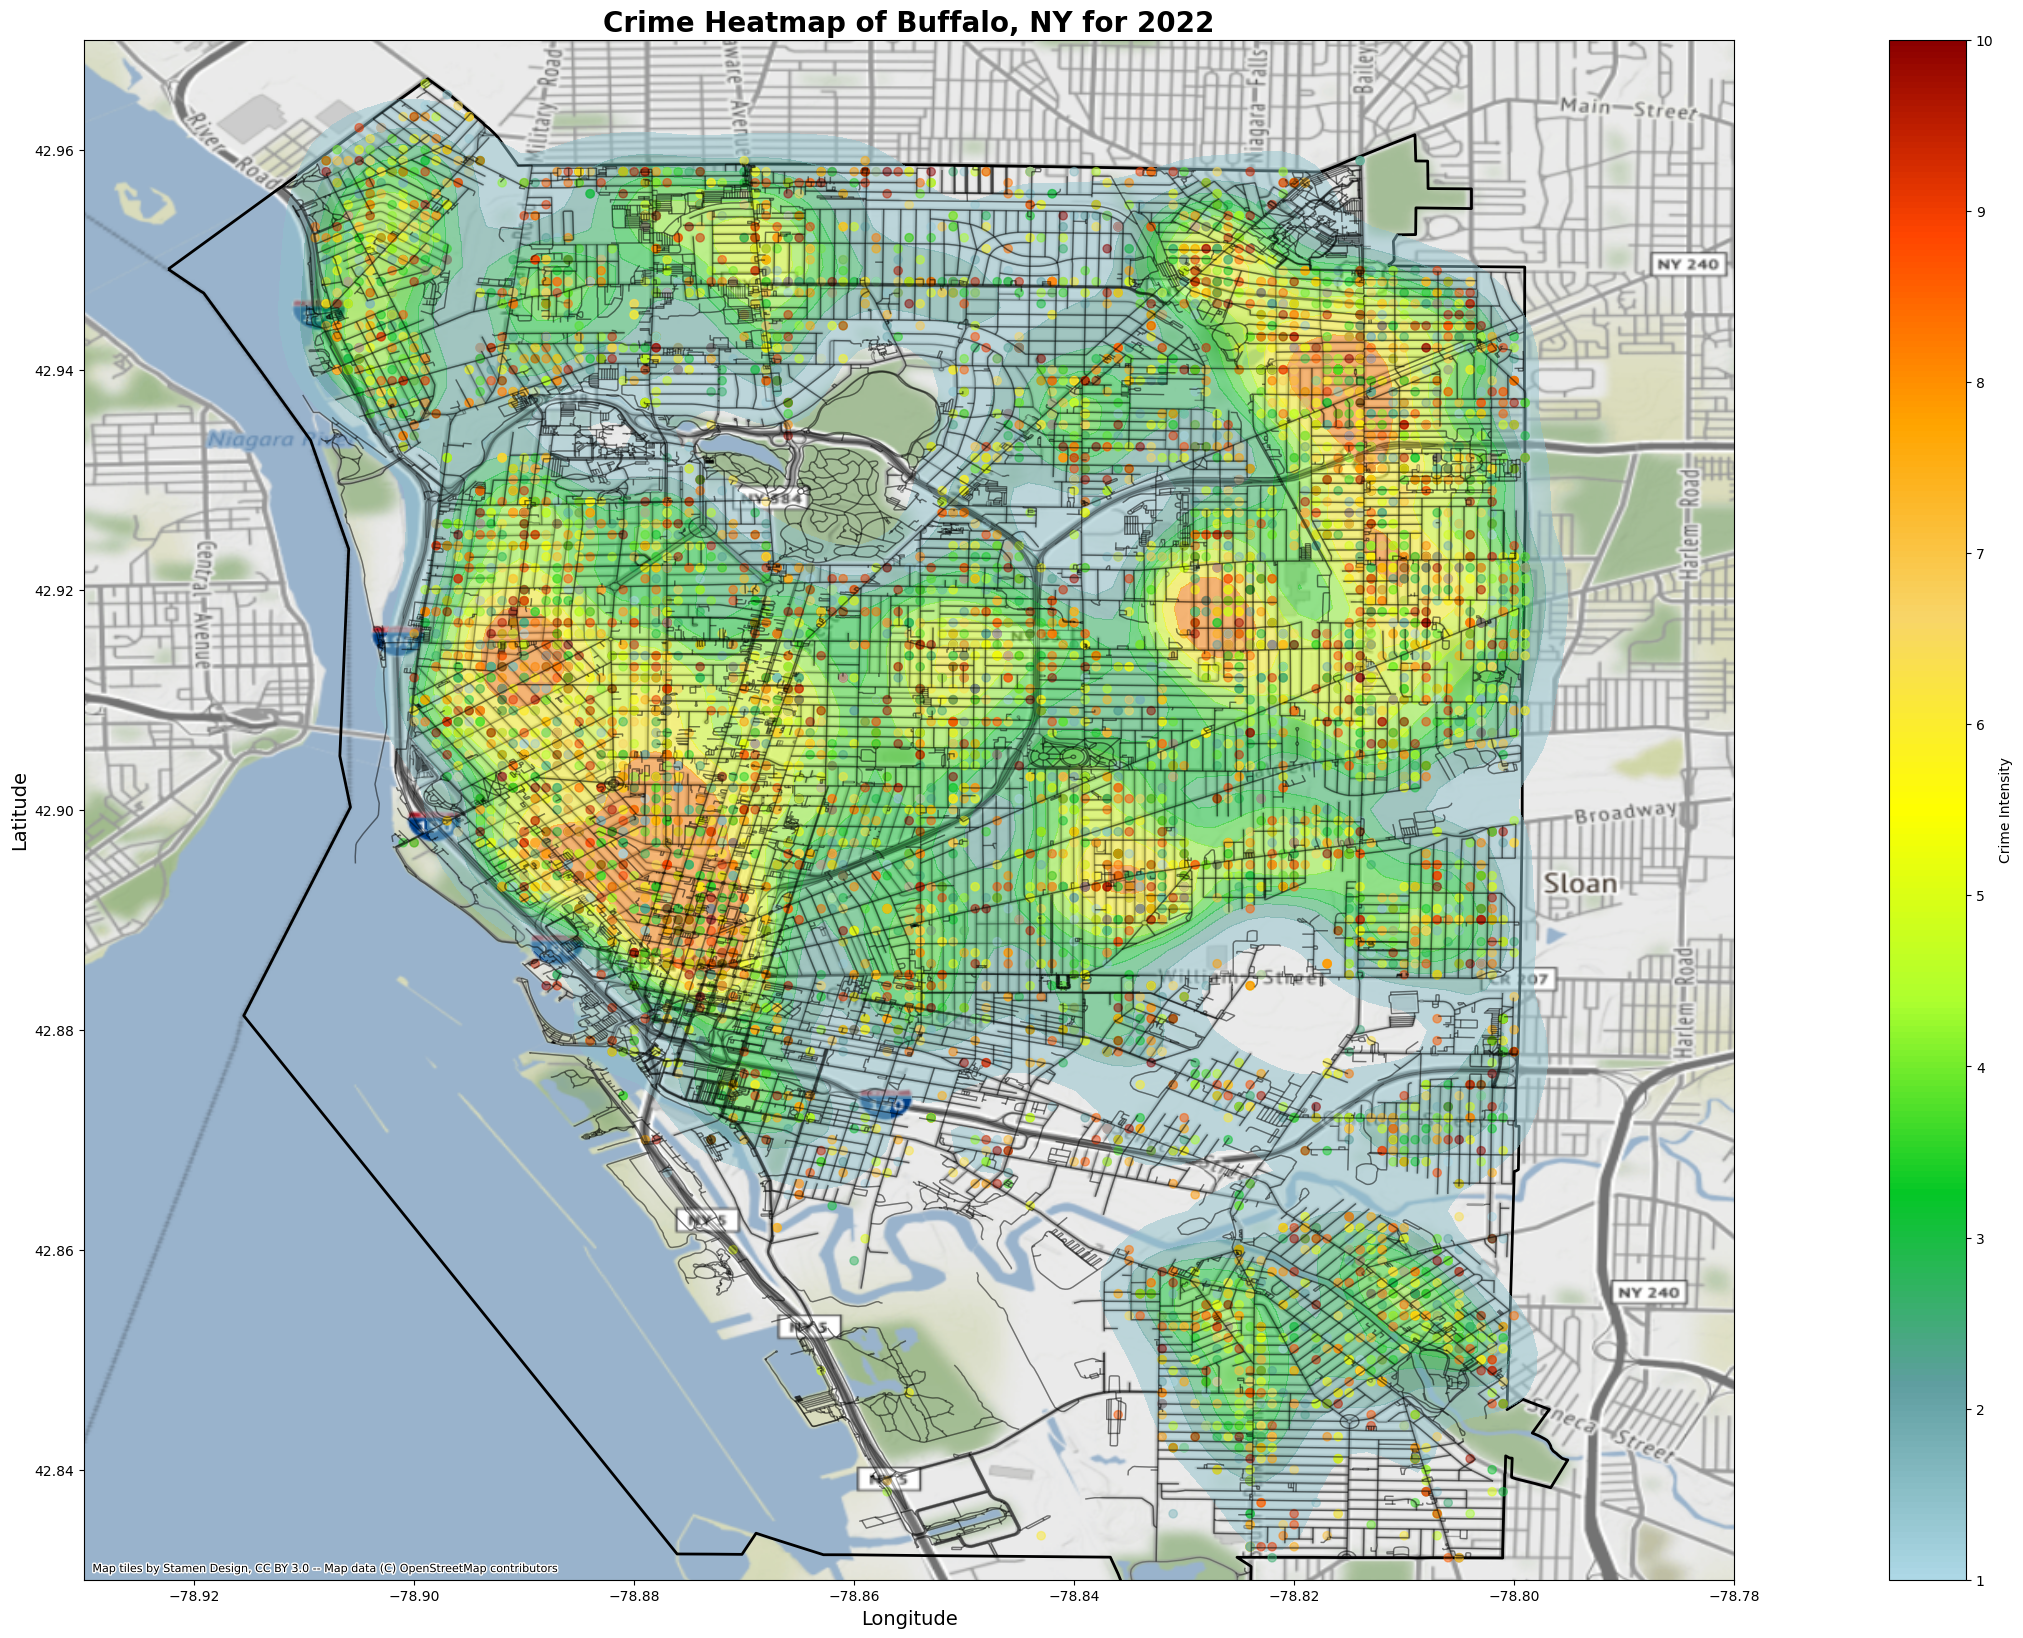

In [8]:
import seaborn as sns
import contextily as ctx
import matplotlib as mpl

# Set the projection for the basemap
web_mercator_crs = "EPSG:4326"
gdf.crs = "EPSG:4326"
gdf_web_mercator = gdf.to_crs(web_mercator_crs)
buffalo_neighborhoods_web_mercator = buffalo_neighborhoods.to_crs(web_mercator_crs)

# Plot size
fig, ax = plt.subplots(figsize = (40, 20))

# The streets of Buffalo city
street_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1, alpha=0.3)

# The outline of Buffalo city
buffalo_neighborhoods.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2)

# KDE Plot
sns.kdeplot(
    data=gdf_web_mercator,
    x="longitude",
    y="latitude",
    weights="weights",
    bw_adjust=0.5,  # Adjust bandwidth, smaller values for narrower bandwidth
    cmap=custom_cmap,  # Choose a colormap
    fill=True,  # Shade the plot for better visualization
    alpha=0.5,  # Adjust the transparency
    ax=ax,
    legend=True,
    thresh=0.05
)

# control map limits, necessary to prevent some outliers from affecting the focus on the city
plt.ylim(42.83, 42.97)
plt.xlim(-78.93, -78.78)

scatter = gdf.plot(ax=ax, cmap=custom_cmap, alpha=0.5)

# Create a color bar
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(crime_weights.values()), vmax=max(crime_weights.values())), cmap=custom_cmap), ax=ax)
cbar.set_label('Crime Intensity')

# Background image
ctx.add_basemap(ax, crs=web_mercator_crs, alpha=1)

# Set the title for the plot
ax.set_title(f'Crime Heatmap of Buffalo, NY for {year}', fontsize=20, fontweight='bold')

# Set axis labels
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

plt.show()

# Income vs Crime

We will perform a simple visual analysis by comparing the median income of areas with their crime rates. Since we already have a graph with crime intensity by geographic area, we will plot another graph that has the median income by geographic areas. Then, we will perform a visual analysis by juxtaposing the two graphs.

In the below code block, we will find the dataframe that has GEOID along with the Median Income for each census tract.

In [9]:
import requests
import pandas as pd

# Your Census API key goes here
api_key = os.getenv('CENSUS_API_KEY')

# Define the API endpoint
endpoint = 'https://api.census.gov/data/2019/acs/acs5'

# Define the parameters
params = {
    'get': 'NAME,B19013_001E',  # B19013_001E is the code for median household income
    'for': 'tract:*',
    'in': 'state:36 county:029',  # 36 is the state code for New York, 029 is the county code for Erie County, which includes Buffalo
    'key': api_key
}

# Make the API request
response = requests.get(endpoint, params=params)

# Raise an exception if the request was unsuccessful
response.raise_for_status()

# Convert the response to JSON
data = response.json()

# Convert the JSON to a pandas DataFrame, and set the first row as the header
df_geoid_income = pd.DataFrame(data[1:], columns=data[0])

# Convert the median income column to numeric
df_geoid_income['B19013_001E'] = pd.to_numeric(df_geoid_income['B19013_001E'])

# Some values are depicted in negative to show lack of data. We make these values as na to drop them. 
df_geoid_income.loc[df_geoid_income['B19013_001E'] < 0, 'B19013_001E'] = pd.NA
df_geoid_income = df_geoid_income.dropna()
df_geoid_income = df_geoid_income.rename(columns={'B19013_001E': 'Median Income'})

# Note: 'state'+'county'+'tract' is the GEOID
df_geoid_income['GEOID'] = df_geoid_income['state'] + df_geoid_income['county'] + df_geoid_income['tract']
df_geoid_income = df_geoid_income.set_index('GEOID')
df_geoid_income = df_geoid_income.drop(columns=['NAME', 'state', 'county', 'tract'])

df_geoid_income


Median Income
GEOID                     
36029005600        30378.0
36029007700        49554.0
36029009008        74828.0
36029009113       125881.0
36029009301        49725.0
...                    ...
36029014701       107598.0
36029015301        76493.0
36029015401        75616.0
36029015501        53750.0
36029000700        75023.0

[230 rows x 1 columns]

Now, we have the Median Income data for each census tract in Erie county. However, we do not have any Geographic information to plot these incomes on the map. We get the information from Topologically Integrated Geographic Encoding and Referencing (TIGER).  

In [10]:
import geopandas as gpd

# Define the URL for the TIGER/Line shapefiles for Census Tracts in New York State (2019)
# tiger_url = 'https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_36_tract.zip'
tiger_url = 'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_36_tract.zip'

# Read the shapefile from the URL
gdf_tracts = gpd.read_file(tiger_url)

# Filter the GeoDataFrame for Erie County (which includes Buffalo)
gdf_erie = gdf_tracts[gdf_tracts['COUNTYFP'] == '029']

gdf_erie = gdf_erie[['GEOID', 'geometry']]

# Set the index to GEOID
gdf_erie = gdf_erie.set_index('GEOID')

# Convert the DataFrame with income data to a GeoDataFrame
df_geoid_income = gpd.GeoDataFrame(df_geoid_income, geometry=gdf_erie['geometry'])

df_geoid_income.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 230 entries, 36029005600 to 36029000700
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Median Income  230 non-null    float64 
 1   geometry       230 non-null    geometry
dtypes: float64(1), geometry(1)
memory usage: 13.5+ KB


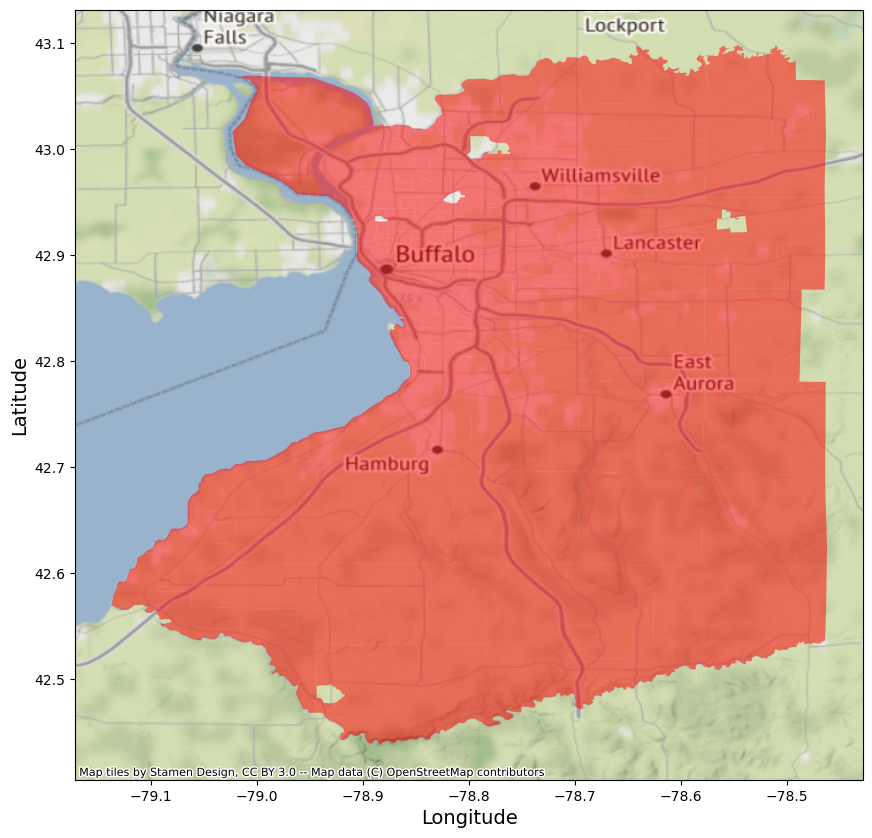

In [11]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(12, 10))
df_geoid_income.plot(ax=ax, color='red', alpha=0.5)
ctx.add_basemap(ax, crs=gdf_erie.crs, alpha=1)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.show()

There is a problem with this dataset. This dataset covers the entire erie county and provides the polygon information for the entire county. We need to truncate this information to cover only the Buffalo City. We develop a buffer around the Buffalo City polygon and find only the polygons completely within this buffered polygon.

In [12]:
# Fetch the geographic data for Buffalo
buffalo_city_outline = ox.geocode_to_gdf('Buffalo, New York, USA')

# Convert the CRS to one that uses meters
df_geoid_income = df_geoid_income.to_crs('EPSG:4326')
buffalo_city_outline = buffalo_city_outline.to_crs('EPSG:4326')

# Create a single polygon for the city of Buffalo
buffalo_city_polygon = buffalo_city_outline.unary_union

# Add a 100m buffer to the city polygon
buffalo_city_polybuffer = buffalo_city_polygon.buffer(0.005)

# Create a mask for the rows in gdf_buffalo where the geometry is within the buffered city_polygon
mask = df_geoid_income.within(buffalo_city_polybuffer)

# Apply the mask to filter the GeoDataFrame
df_geoid_income_buffalo = df_geoid_income[mask]
df_geoid_income_buffalo

Median Income                                           geometry
GEOID                                                                        
36029005600        30378.0  POLYGON ((-78.89627 42.94206, -78.89585 42.944...
36029005802        23074.0  POLYGON ((-78.91245 42.95625, -78.91243 42.956...
36029006902        33750.0  POLYGON ((-78.89272 42.90563, -78.89159 42.906...
36029000800        71496.0  POLYGON ((-78.82373 42.84497, -78.82373 42.845...
36029003000        26473.0  POLYGON ((-78.81394 42.89890, -78.81387 42.901...
...                    ...                                                ...
36029003600        25511.0  POLYGON ((-78.82442 42.92108, -78.82441 42.922...
36029004300        44193.0  POLYGON ((-78.81370 42.94896, -78.81350 42.948...
36029005100        44163.0  POLYGON ((-78.86959 42.95872, -78.86947 42.958...
36029006701        32031.0  POLYGON ((-78.88616 42.91133, -78.88594 42.911...
36029000700        75023.0  POLYGON ((-78.81502 42.84116, -78.81501 42.841...

[78 rows x 2 columns]

In [13]:
# Custom color maps
from matplotlib.colors import LinearSegmentedColormap

colors = ["#add8e6", "#5f9ea0", "#04c726", "#adff2f", "#ffff00", "#f8d568", "#ffa500", "#ff4500", "#8b0000"]
custom_cmap_income = LinearSegmentedColormap.from_list("custom_cmap", colors[::-1])

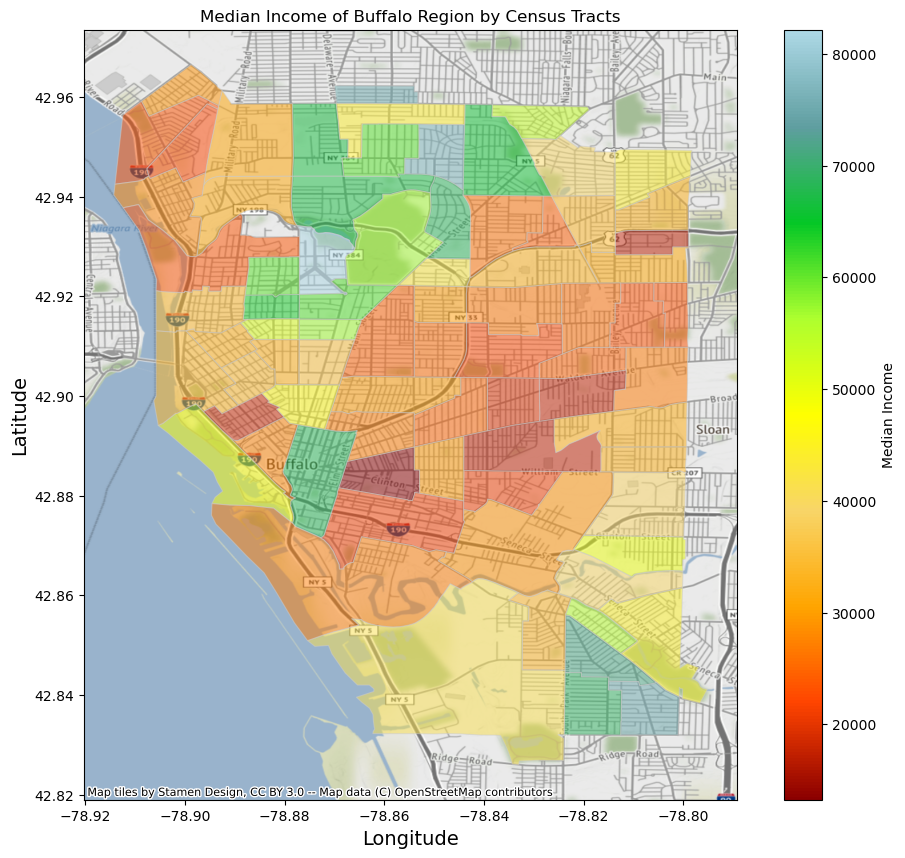

In [14]:
# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))
df_geoid_income_buffalo.plot(column='Median Income', cmap=custom_cmap_income, linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.5, legend=True, legend_kwds={'label': 'Median Income'})
ctx.add_basemap(ax, crs=df_geoid_income.crs, alpha=1)
ax.set_title('Median Income of Buffalo Region by Census Tracts')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.show()

We found little correlation with income and weighted crime intensity. We hypothesize that this is because there is stronger correlation with the population. To prove our hypothesis, we plot the map of buffalo with population for each census tract.

In [15]:
# Define the API endpoint
endpoint = 'https://api.census.gov/data/2019/acs/acs5'

# Define the parameters
params = {
    'get': 'NAME,B01001_001E',  # B01001_001E is the code for total population
    'for': 'tract:*',
    'in': 'state:36 county:029',  # 36 is the state code for New York, 029 is the county code for Erie County, which includes Buffalo
    'key': api_key
}

# Make the API request
response = requests.get(endpoint, params=params)

# Raise an exception if the request was unsuccessful
response.raise_for_status()

# Convert the response to JSON
data = response.json()

# Convert the JSON to a pandas DataFrame, and set the first row as the header
df_geoid_population = pd.DataFrame(data[1:], columns=data[0])

# Convert the population column to numeric
df_geoid_population['B01001_001E'] = pd.to_numeric(df_geoid_population['B01001_001E'])

# Replace negative values with NaN
df_geoid_population.loc[df_geoid_population['B01001_001E'] < 0, 'B01001_001E'] = pd.NA

# Add a column for GEOID (state + county + tract)
df_geoid_population['GEOID'] = df_geoid_population['state'] + df_geoid_population['county'] + df_geoid_population['tract']
df_geoid_population = df_geoid_population.rename(columns={'B01001_001E': 'Population'})
df_geoid_population = df_geoid_population[['GEOID', 'Population']]
df_geoid_population = df_geoid_population.set_index('GEOID')
# Print the DataFrame
df_geoid_population = gpd.GeoDataFrame(df_geoid_population, geometry=gdf_erie['geometry'])

# Create a mask for the rows in gdf_buffalo where the geometry is within the buffered city_polygon
mask_2 = df_geoid_population.within(buffalo_city_polybuffer)

df_geoid_population_buffalo = df_geoid_population[mask_2]
df_geoid_population_buffalo

Population                                           geometry
GEOID                                                                     
36029005600      3862.0  POLYGON ((-78.89627 42.94206, -78.89585 42.944...
36029006201      2084.0  POLYGON ((-78.88859 42.93404, -78.88844 42.935...
36029005802      4478.0  POLYGON ((-78.91245 42.95625, -78.91243 42.956...
36029006902      4267.0  POLYGON ((-78.89272 42.90563, -78.89159 42.906...
36029000800      4606.0  POLYGON ((-78.82373 42.84497, -78.82373 42.845...
...                 ...                                                ...
36029003600      2708.0  POLYGON ((-78.82442 42.92108, -78.82441 42.922...
36029004300      6781.0  POLYGON ((-78.81370 42.94897, -78.81350 42.948...
36029005100      4505.0  POLYGON ((-78.86959 42.95872, -78.86947 42.958...
36029006701      3171.0  POLYGON ((-78.88616 42.91134, -78.88594 42.911...
36029000700      3538.0  POLYGON ((-78.81502 42.84116, -78.81501 42.841...

[80 rows x 2 columns]

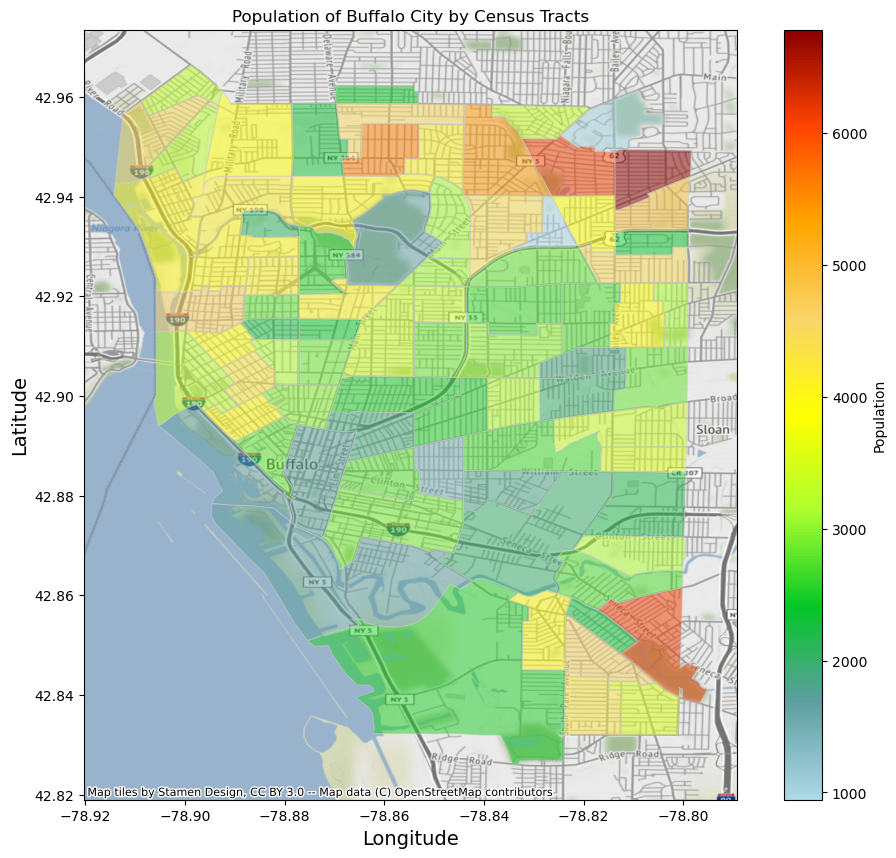

In [16]:
# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))
df_geoid_population_buffalo.plot(column='Population', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.5, legend=True, legend_kwds={'label': 'Population'})
ctx.add_basemap(ax, crs=df_geoid_income.crs, alpha=1)
ax.set_title('Population of Buffalo City by Census Tracts')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.show()

There seems to be little correlation between population and crime. One key area that stands out is the Buffalo downtown where the crime intensity seems to be very high and population very low. We hypothesize that this may be because of the frequent travellers to downtown for personal or professional work due to the number of corporate offices that can be seen there. 

To effectively answer these questions of why or how about Crime Incidents, further analysis is required. The most obvious indicators of crime such as Population and Income levels seems to show little correlation here.

In [17]:
data = crime_incidents_data
data.head()

case_number        incident_datetime incident_type_primary   
0  22-0010366  2022-01-01T00:00:00.000         LARCENY/THEFT  \
1  21-0010692  2022-01-01T00:00:00.000         LARCENY/THEFT   
2  22-0010039  2022-01-01T00:36:22.000               ASSAULT   
3  22-0010047  2022-01-01T00:46:00.000              BURGLARY   
4  22-0010048  2022-01-01T00:46:06.000               ASSAULT   

                                incident_description parent_incident_type   
0  Buffalo Police are investigating this report o...                Theft  \
1  Buffalo Police are investigating this report o...                Theft   
2  Buffalo Police are investigating this report o...              Assault   
3  Buffalo Police are investigating this report o...  Breaking & Entering   
4  Buffalo Police are investigating this report o...              Assault   

  hour_of_day day_of_week             address_1     city state  ...   
0           6    Saturday  0 Block DEERFIELD AV  Buffalo    NY  ...  \
1           0    Saturday  1100 Block HERTEL AV  Buffalo    NY  ...   
2           0    Saturday   200 Block LANDON ST  Buffalo    NY  ...   
3           0    Saturday    100 Block HAGEN ST  Buffalo    NY  ...   
4           0    Saturday   100 Block SCHOOL ST  Buffalo    NY  ...   

  census_tract census_block census_block_group  neighborhood_1   
0          170         2013                  2  Delavan Grider  \
1           51         4002                  4      North Park   
2        33.02         2006                  2     Masten Park   
3           37         1004                  1   Schiller Park   
4        69.01         3010                  3       West Side   

  police_district council_district tractce20 geoid20_tract geoid20_blockgroup   
0      District E           MASTEN    017000   36029017000       360290170002  \
1      District D         DELAWARE    005100   36029005100       360290051004   
2      District C           MASTEN    003302   36029003302       360290033022   
3      District E          LOVEJOY    003700   36029003700       360290037001   
4      District B          NIAGARA    006901   36029006901       360290069013   

     geoid20_block  
0  360290170002013  
1  360290051004002  
2  360290033022006  
3  360290037001004  
4  360290069013010  

[5 rows x 27 columns]

In [18]:
# Convert the datetime_column to datetime format
data['datetime_column'] = pd.to_datetime(data['incident_datetime'])

# Extract the month
data['month'] = data['datetime_column'].dt.strftime('%B')

print(data.columns)

# Print the updated DataFrame
# data.head()

# Group by month and count the IDs
monthly_counts = data.groupby(data['month'])['case_number'].count()

monthly_counts_sorted = monthly_counts.sort_values(ascending=True)
# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Sort the DataFrame by the month order
monthly_counts_sorted = monthly_counts.reindex(month_order)

# avergae temperature of 2022
temperature_order = [ 21.9,	28.5,	38.3,	45.5,	61.3,	66.7,	72.4,	72.7,	63.3,	52.4,	43.3,	32.0]

Index(['case_number', 'incident_datetime', 'incident_type_primary',
       'incident_description', 'parent_incident_type', 'hour_of_day',
       'day_of_week', 'address_1', 'city', 'state', 'location', 'latitude',
       'longitude', 'created_at', 'census_tract_2010',
       'census_block_group_2010', 'census_block_2010', 'census_tract',
       'census_block', 'census_block_group', 'neighborhood_1',
       'police_district', 'council_district', 'tractce20', 'geoid20_tract',
       'geoid20_blockgroup', 'geoid20_block', 'datetime_column', 'month'],
      dtype='object')


In [19]:
month_order

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [20]:
monthly_counts

month
April        780
August       967
December     679
February     597
January      714
July         997
June         864
March        760
May          776
November     440
October      946
September    957
Name: case_number, dtype: int64

In [21]:
monthly_counts_sorted

month
January      714
February     597
March        760
April        780
May          776
June         864
July         997
August       967
September    957
October      946
November     440
December     679
Name: case_number, dtype: int64

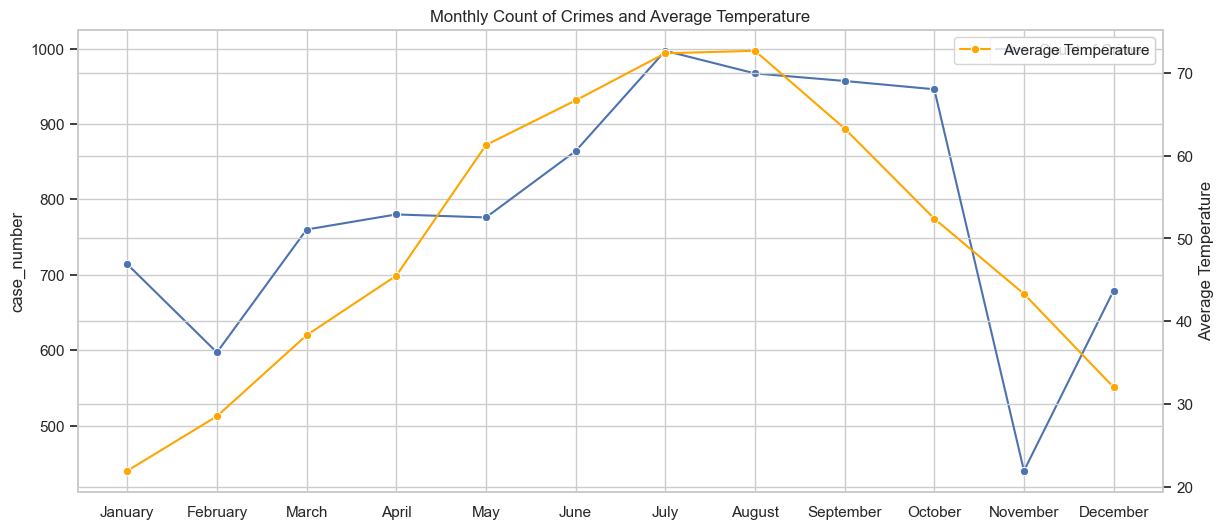

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(14, 6))

# Plot the line graph using Seaborn
sns.lineplot(x=month_order, y=monthly_counts_sorted, marker='o', label='Count of Crimes')
# sns.lineplot(x=month_order, y=temperature_order, marker='x', label='Average Temperature')
# Create a secondary y-axis
ax2 = plt.twinx()

# Plot the average temperature
sns.lineplot(x=month_order, y=temperature_order, marker='o', label='Average Temperature', color='orange', ax=ax2)

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Count of Crimes / Average Temperature')
ax2.set_ylabel('Average Temperature')
plt.title('Monthly Count of Crimes and Average Temperature')

# Set the limits of the secondary y-axis
# ax2.set_ylim(bottom=0)  # Assuming temperature values are non-negative

# Manually adjust x-axis tick positions and labels
plt.xticks(range(len(month_order)), month_order, rotation=20)

# Display the plot
plt.legend()
plt.show()